In [1]:
%matplotlib inline
import math, random as rnd
from typing import List, Tuple, Callable
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 12
rnd.seed()

In [2]:
def ncombinations(n: int, k: int) -> int:
    if n < k or n < 0 or k < 0:
        return 0
    if k == 0:
        return 1
    maxk = max(k, n - k)
    k = min(k, n - k)
    
    dividend, divider = 1, 1
    for i in range(1, k + 1):
        dividend *= (maxk + i)
        divider *= i
        
    return dividend//divider

def get_units_dist(rnd_func: Callable[[], float], d: int, c: int) -> List[int]:
    """ Список позиций (номеров от 0 до d - 1), на которых стоят единицы
        (описывает случайный двоичный вектор длины d, имеющий ровно c единиц).
        Если d < c или d < 0 или с < 0, возвращает None
        Параметры:
        rnd_func -- функция, возвращающая случайное число из диапазона [0; 1)
        d -- длина двоичного вектора
        с -- количество единиц
    """
    if d < c or d < 0 or c < 0:
        return None
    if c == 0:
        return [0]*d
    if d == c:
        return range(d)
    
    res = [-1]*c
    i = 0                               # текущая позиция
    n, k = d - 1, c                     # оставшиеся позиции и машины
    nopts = ncombinations(d, c)         # кол-во размещений при i заданных позициях
    true_nopts = nopts*c//d             # ncombinations(d - 1, c - 1) --
                                        # кол-во размещений из числа тех, что выше,
    j = -1                               # где на i-й позиции - машина
    while k != 0:
        prob = true_nopts/nopts
        
        # Пересчитываем вероятность с учетом задания i-й (текущей) позиции
        # и, если выпала машина, уменьшаем число оставшихся машин
        if rnd_func() < prob:
            j += 1
            res[j] = i
            nopts = true_nopts
            if n != 0:
                true_nopts = true_nopts*(k-1)//n
            k -= 1
        else:
            nopts -= true_nopts
            true_nopts = true_nopts*(n-k+1)//n
        n -= 1
        i += 1
    
    return res

def mh_wins_frac(nobservs: int, rnd_func: Callable[[], float] = rnd.random,
                  d: int = 3, c: int = 1, n: int = 0, g: int = 1) -> Tuple[float]:
    """ Возвращает кортеж (switch_wins_frac, retain_wins_frac), подсчитывая долю
        выигрышей на nobservs случайных размещениях (парадокс Монти-Холла),
        где switch_wins_frac - доля выигрышей при выборе 2-й двери вместо 1-й,
        выбранной изначально, retain_wins_frac - при выборе 1-й двери.
        Если хотя бы один из целочисленных параметров меньше 0
        или d < 3 или d < c или n > c или g > d - c, возвращает None
        Параметры:
        nobservs -- количество случайно выбираемых размещений
        rnd_func -- функция, возвращающая случайное число
                    из диапазона [0; 1) (по умолчанию random.random())
        d -- количество дверей (по умолчанию 3)
        c -- количество машин (по умолчанию 1)
        n -- количество открытых ведущим машин (по умолчанию 0)
        g -- количество открытых ведущим коз (по умолчанию 1)
    """
    if nobservs < 0 or d < 3 or c < 0 or n < 0 or g < 0\
        or d < c or n > c or g > d - c:
        return None
    switch_nwins, retain_nwins, n_effobservs = 0, 0, 0
    
    for i in range(nobservs):
        # Случайным образом получаем размещение
        dist = [0]*d
        car_poss = get_units_dist(rnd_func, d, c)
        for pos in car_poss:
            dist[pos] = 1
        
        # Если нельзя открыть n машин и g коз, не открывая
        # 2-ю дверь -- переходим к следующей итерации
        car_at_1, car_at_2 = dist[0], dist[1]
        goat_at_1, goat_at_2 = 1 - car_at_1, 1 - car_at_2
        if c - car_at_1 - car_at_2 < n\
            or d - c - goat_at_1 - goat_at_2 < g:
            continue
        
        # Если ведущий открыл 2-ю дверь,
        # переходим к следующей итерации
        if car_at_2 == 1 and n != 0\
            and rnd_func() < n/(c - car_at_1):
            continue
        if goat_at_2 == 1 and g != 0\
            and rnd_func() < g/(d - c - goat_at_1):
            continue
        
        switch_nwins += car_at_2
        retain_nwins += car_at_1
        n_effobservs += 1

    return (switch_nwins/n_effobservs, retain_nwins/n_effobservs)

def mh_switch_winprob(d: int, c: int, n: int, g: int) -> float:
    return (c - n - c/d)/(d - n - g - 1)

def mh_retain_winprob(d: int, c: int, n: int = None, g: int = None) -> float:
    return c/d

Text(0.5,0,'Retaining')

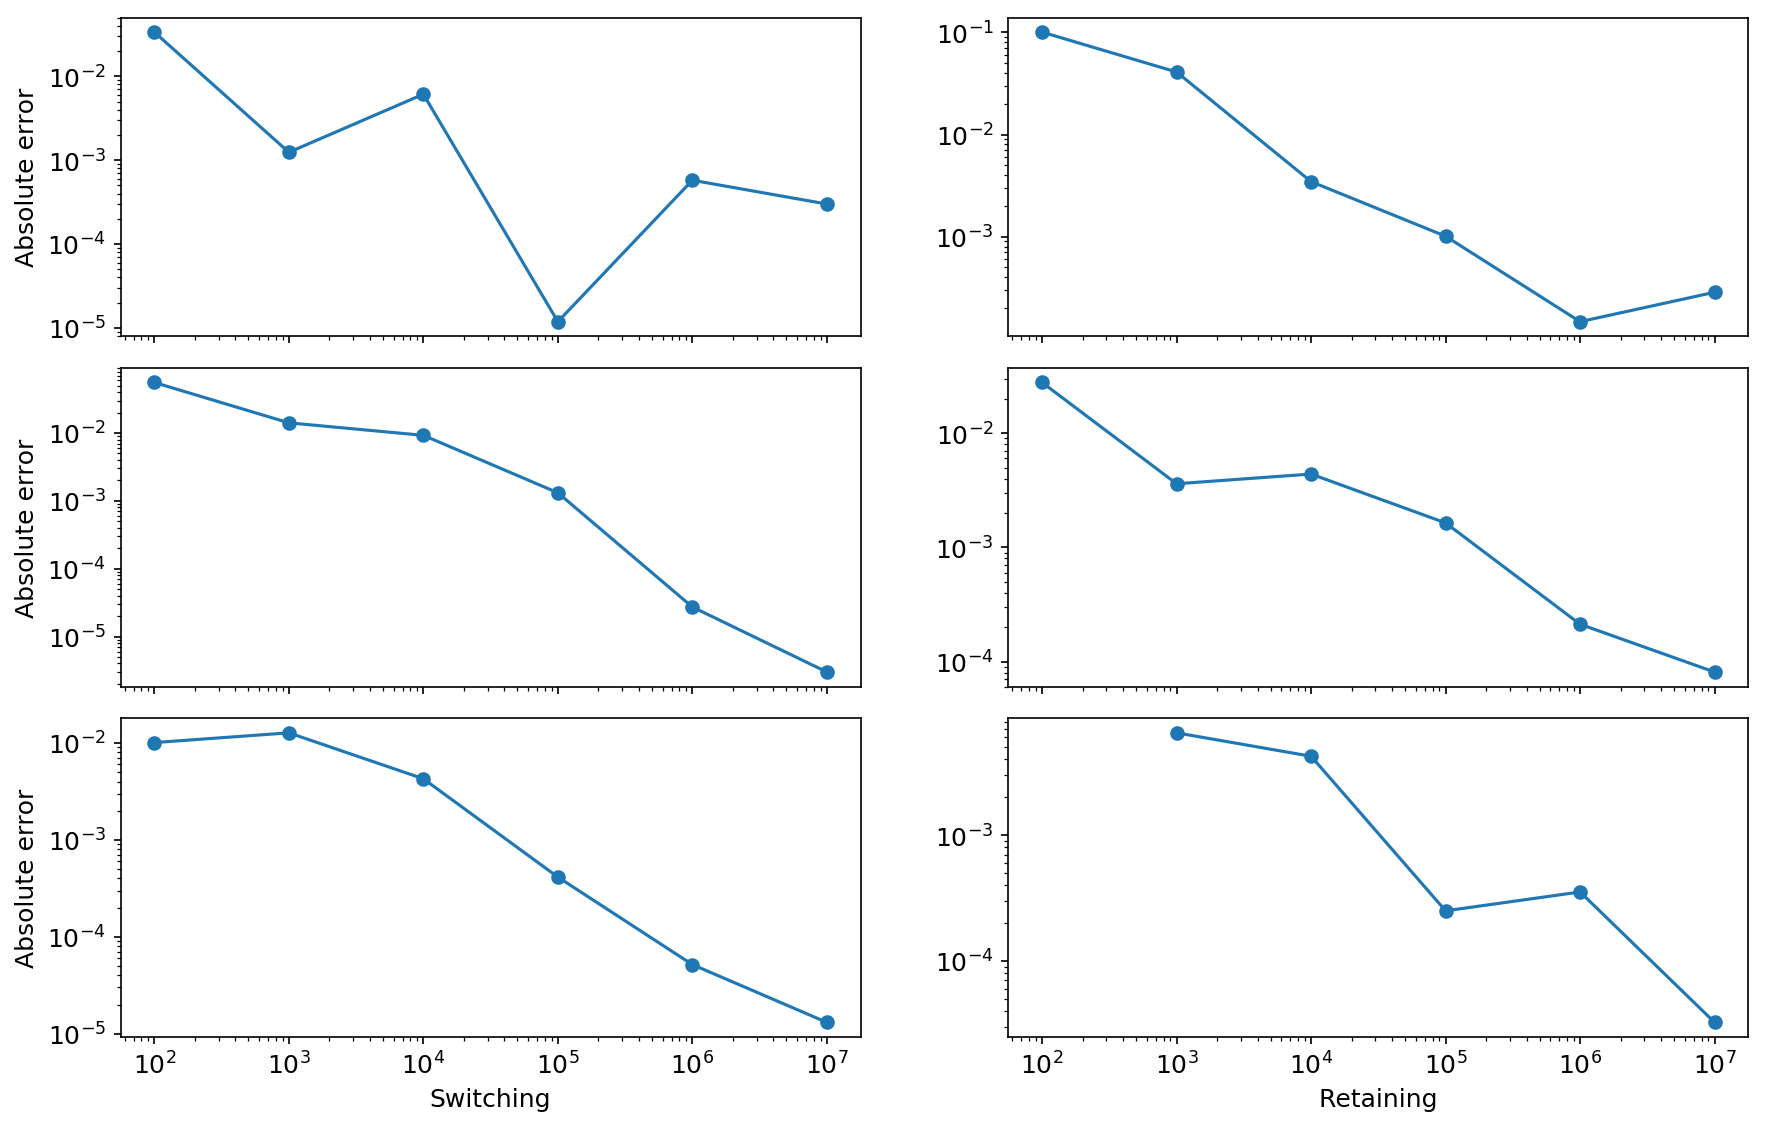

In [3]:
nplots = 3
D = 9; C = 3; N = 2; G = 3
fig, axs = plt.subplots(nplots, 2, sharex=True, sharey=False)
fig.set_size_inches(14, 9)
fig.subplots_adjust(hspace=0.1)

for i in range(nplots):
    nobserves_list = [10**n for n in range(2, 8)]
    results = [mh_wins_frac(nobserves, d = D, c = C, n = N, g = G)
               for nobserves in nobserves_list]
    prob_err1 = [abs(res[0] - mh_switch_winprob(D, C, N, G)) for res in results]
    prob_err2 = [abs(res[1] - mh_retain_winprob(D, C, N, G)) for res in results]
    
    axs[i, 0].loglog(nobserves_list, prob_err1, 'o-')
    axs[i, 0].set_ylabel('Absolute error')
    axs[i, 1].loglog(nobserves_list, prob_err2, 'o-')

axs[nplots-1, 0].set_xlabel('Switching')
axs[nplots-1, 1].set_xlabel('Retaining')